In [3]:
import numpy as np

import temporal_fusion_transformer as tft
import polars as pl
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotx
from absl_extra.logging_utils import setup_logging
from datetime import timedelta, datetime
from matplotlib import dates as mdates
from temporal_fusion_transformer.src.experiments.util import time_series_to_array
import seaborn as sns

matplotlib.style.use(matplotx.styles.dufte)
setup_logging(log_level="INFO")

In [4]:
electricity = tft.experiments.Electricity()
preprocessor = electricity.reload_preprocessor("../data/electricity/preprocessor.msgpack")
model = electricity.reload_model("../data/electricity/model.msgpack")

In [5]:
# Filter out 1 entity and last 7 days (so plot if not too large)
mt_124_df = (
    pl.read_parquet("../data/electricity/test.parquet")
    .filter(pl.col("id") == "MT_124")
    .pipe(lambda df: df.with_columns(timestamp=pl.Series(preprocessor.restore_timestamps(df))))
    .filter(pl.col("timestamp") >= (pl.col("timestamp").max() - timedelta(days=8)))
)
mt_124_df

power_usage,year,month,hour,day,day_of_week,id,timestamp
f32,u16,u8,u8,u8,u8,str,datetime[μs]
389.952148,2014,8,0,31,7,"""MT_124""",2014-08-31 00:00:00
413.87561,2014,8,1,31,7,"""MT_124""",2014-08-31 01:00:00
357.655518,2014,8,2,31,7,"""MT_124""",2014-08-31 02:00:00
324.162689,2014,8,3,31,7,"""MT_124""",2014-08-31 03:00:00
272.727264,2014,8,4,31,7,"""MT_124""",2014-08-31 04:00:00
165.071777,2014,8,5,31,7,"""MT_124""",2014-08-31 05:00:00
144.736847,2014,8,6,31,7,"""MT_124""",2014-08-31 06:00:00
102.870811,2014,8,7,31,7,"""MT_124""",2014-08-31 07:00:00
163.875595,2014,8,8,31,7,"""MT_124""",2014-08-31 08:00:00


In [6]:
tf_ds = preprocessor.convert_dataframe_to_tf_dataset(mt_124_df)
tf_ds

Applying scalers...:   0%|          | 0/1 [00:00<?, ?it/s]

Applying label encoders...:   0%|          | 0/4 [00:00<?, ?it/s]

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [7]:
x_batch = tf_ds.batch(8).as_numpy_iterator().next()[0]

In [8]:
y = model(x_batch)

2023-10-02 01:02:02,624:[xla_bridge.py:603->backends()]:INFO: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-10-02 01:02:02,624:[xla_bridge.py:603->backends()]:INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-10-02 01:02:02,625:[xla_bridge.py:603->backends()]:INFO: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


In [13]:
y.logits[..., 0, 0].shape

(2, 24)

In [28]:
y.logits[0, :, 0, 2]

Array([0.0074296 , 0.00747423, 0.00748558, 0.00736345, 0.00732938,
       0.00739109, 0.00745331, 0.00744369, 0.0073313 , 0.00740047,
       0.00740861, 0.00744276, 0.00740029, 0.00740891, 0.00746278,
       0.00735311, 0.00731138, 0.00738321, 0.00737201, 0.0074507 ,
       0.00740628, 0.00734099, 0.0075026 , 0.00733108], dtype=float32)

In [12]:
y.static_flags.shape

(2, 1)

In [13]:
y.historical_flags.shape

(2, 168, 5)

In [15]:
y.future_flags.shape

(2, 24, 5)

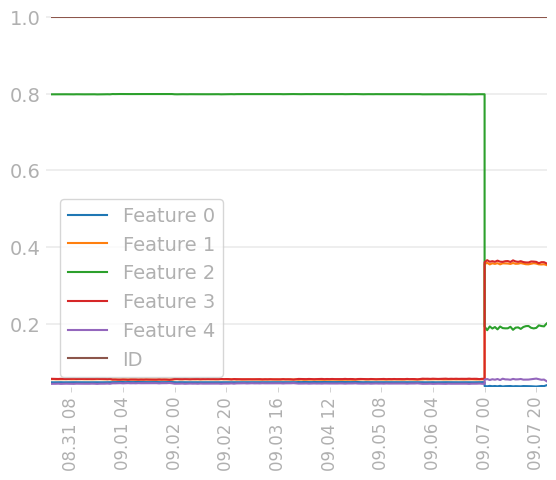

In [71]:
for i in range(5):
    past_df = preprocessor.inverse_transform(
        time_series_to_array(x_batch[:, :168]),
        time_series_to_array(y.historical_flags[..., i][..., None]),
    )
    future_df = preprocessor.inverse_transform(
        time_series_to_array(x_batch[:, 168:]),
        time_series_to_array(y.future_flags[..., i][..., None]),
    )
    plt.plot(
        preprocessor.restore_timestamps(past_df) + preprocessor.restore_timestamps(future_df),
        preprocessor.preprocessor["target"]["MT_124"]
        .transform(
            np.concatenate(
                [past_df["power_usage"].to_numpy(), future_df["power_usage"].to_numpy()]
            ).reshape((-1, 1))
        )
        .reshape(-1),
    )

static_df = preprocessor.inverse_transform(
    time_series_to_array(x_batch),
    time_series_to_array(np.concatenate([y.static_flags[:, None] for i in range(192)], axis=1)),
)
plt.plot(
    preprocessor.restore_timestamps(static_df),
    preprocessor.preprocessor["target"]["MT_124"]
    .transform(static_df["power_usage"].to_numpy().reshape((-1, 1)))
    .reshape(-1)
    .reshape(-1),
)
plt.legend([f"Feature {i}" for i in range(5)] + ["ID"])
plt.xticks(rotation=90, fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m.%d %H"))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=20))